# Expectation maximization

$$ \begin{eqnarray} 
 z_i &\sim & Multinomial(\phi) \\
 x_i|z_i & \sim & \mathcal{N}(\mu_{z_i}, \sigma_{z_i})) \\
\end{eqnarray}$$ 


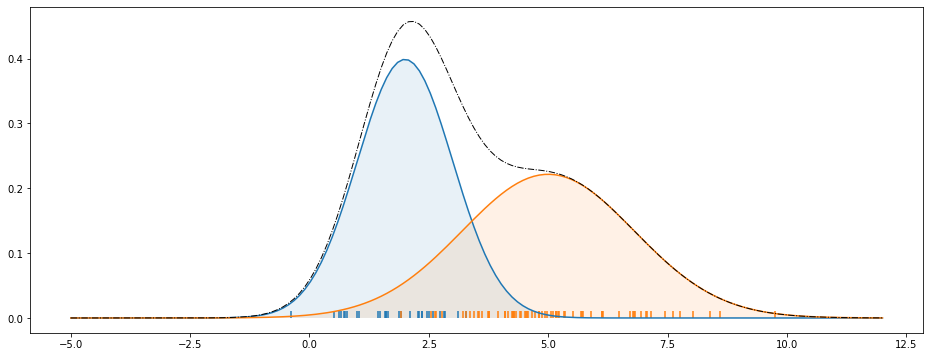

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

np.random.seed(654)
# Draw samples from two Gaussian w.p. z_i ~ Bernoulli(phi)
generative_m = np.array([stats.norm(2, 1), stats.norm(5, 1.8)])
z = stats.bernoulli(0.75).rvs(100)
x_i = np.array([g.rvs() for g in generative_m[z]])

# plot generated data and the latent distributions
x = np.linspace(-5, 12, 150)
plt.figure(figsize=(16, 6))
plt.plot(x, generative_m[0].pdf(x))
plt.plot(x, generative_m[1].pdf(x))
plt.plot(x, generative_m[0].pdf(x) + generative_m[1].pdf(x), lw=1, ls='-.', color='black')
plt.fill_betweenx(generative_m[0].pdf(x), x, alpha=0.1)
plt.fill_betweenx(generative_m[1].pdf(x), x, alpha=0.1)
plt.vlines(x_i, 0, 0.01, color=np.array(['C0', 'C1'])[z])
plt.show()

# Log likelihood
Let $\theta = \{ \mu, \sigma \}$.
$$\ell(\theta) = \sum_{i=1}^n \log P(x_i; \theta)  $$

Or in vector form:

$$\ell(\theta) = \log P(x; \theta)  $$

This log likelihood function cannot be solved directly as it not includes the latent variable $z$.

$$ \ell(\theta) = \sum_{k=1}^K \log P(x | z_k; \theta) P(z_k) $$

## Continuous form

$$ \begin{eqnarray}
\ell(\theta) & = & \int \log P(x | \theta, z) P(z) dz \\
\log P(x; \theta)& = & \int \log P(x | \theta, z) P(z) dz
\end{eqnarray}$$





**Jensens inequality:**
*Only for concave functions*
$$ E[f(X)] \le f(E[X]) $$

**Jensens equality:**
$$ E[f(X)] = f(E[X]) \iff X = E[X] $$

## Evidence Lower BOund


Multiply the **evidence** w/ an arbitrary distribution over $Z, \quad \frac{Q(z)}{Q(z)} = 1$ 

$$ \begin{eqnarray}
\log P(x; \theta)& = & \int \log Q(z) \frac{ P(x | \theta, z) P(z)}{Q(z)} dz \\
& = & \log E_{z \sim Q}[ \frac{ P(x | \theta, z) P(z)}{Q(z)}] \\
\end{eqnarray}$$

As the log function is a concave function, we can apply Jensen's inequality.

$$ \begin{eqnarray}
\log P(x; \theta)& = & \log E_{z \sim Q}[ \frac{ P(x | \theta, z) P(z)}{Q(z)}] \\
& \ge &  E_{z \sim Q}[ \log \frac{ P(x | \theta, z) P(z)}{Q(z)}]
\end{eqnarray}$$



Resulting in a lower bound on the evidence called the **ELBO**:

$$ \begin{eqnarray}
\log P(x; \theta)& \ge &  E_{z \sim Q}[ \log \frac{ P(x | \theta, z) P(z)}{Q(z)}]
\end{eqnarray}$$


# Now what?

Jensen's inequality holds to equaltiy if and only if $X = E[X]$. This will be the case if we choose a distribution that leads to:

$$ \begin{eqnarray}
\frac{P(x|z) P(z)}{Q(z)} &=& \frac{P(x, z)}{Q(z)} = c
\end{eqnarray}$$

Wich means that 

$$ P(x, z; \theta) \propto Q(z) $$

A next requirement is that $\int Q(z) dz = 1$ (requirement of probability distribution).

$$ \begin{eqnarray}
\int \frac{P(x, z; \theta)}{\int P(x, z; \theta) dz} dz &=& 1 \\
\end{eqnarray}$$

This will lead to:

$$ \begin{eqnarray}
Q(z) &=& \frac{P(x, z; \theta)}{\int P(x, z; \theta) dz}  \\
&=& \frac{P(x, z; \theta)}{\int P(x; \theta)} \\
&=& P(z|x; \theta)
\end{eqnarray}$$

## Gaussian mixture model

### Expectation
Given a Gaussian mixture model, observed data points $x$ and current parameters $\theta_t$ find $Q(z; \theta_t) = P(z|x; \theta_t)$.


In [4]:
# Data points x
x_i

array([ 4.28244273,  4.66972656,  3.35275075,  2.36158676,  3.74751768,
        9.75240814,  5.15756521,  4.80213993,  5.90145058,  1.91271217,
        4.71273852,  2.36241133,  1.61084671,  6.71697406,  3.11442326,
        5.15422491,  5.09580485,  2.11274369,  6.76574344,  1.48354695,
        2.65304672,  6.81892055,  2.77103106,  5.06418788,  5.72517362,
        3.54313443,  5.67858554,  1.03222311,  1.63983108,  5.51107055,
        0.65124788,  4.97843073,  4.32989217,  2.28812021,  4.51797044,
        4.52825271,  6.93340533,  4.94273792,  2.54969132,  0.78634279,
        4.81172184,  5.19576022,  6.11967179,  3.5235398 ,  0.75307613,
        4.23428727,  7.15230773,  2.83345813,  8.60608829,  4.27073679,
        7.75388195,  6.79259227,  0.62404892,  4.26260727,  4.09584051,
        3.26993383,  4.86431429,  8.38977374,  6.48961063,  4.09783105,
        4.40498267,  3.27433241,  7.44164281,  7.62286463,  3.21797707,
        4.42538064,  7.06135769,  3.94733606,  1.91385988,  5.23

In [10]:
import torch
from torch import nn
import torch.distributions as dist
import torch.nn.functional as F

In [11]:
x_i = torch.tensor(x_i, dtype=torch.float)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


<BarContainer object of 100 artists>

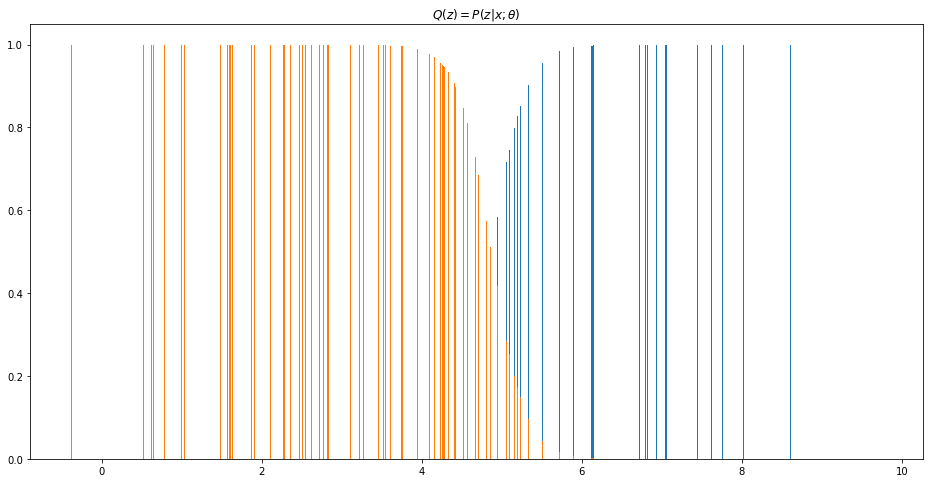

In [12]:
torch.manual_seed(1)
g in better poste-rior a
k = torch.tensor([2])
mu = dist.Uniform(x_i.min(), x_i.max()).sample(k) 
std = torch.ones(k)

def expectation(x, mu, std, k):
    qz = torch.zeros((k, x.shape[0]))
    
    for z in range(k):
        qz[z] = dist.Normal(mu[z], std[z]).log_prob(x).exp() 
    
    # normalize zo that marginalizing z would lead to p = 1
    qz = qz / qz.sum(0)
    return qz

qz = expectation(x_i, mu, std, k)    

plt.figure(figsize=(16, 8)) 
plt.title(r"$Q(z) = P(z|x; \theta)$")
plt.bar(x_i, qz[0], width=0.01)
plt.bar(x_i, qz[1], width=0.01)

### Maximization

Optimize $\theta$ with the $Q(z; \theta_t)$ found in the expectation step.
$$ \text{ELBO} =  \sum_{z_i} Q(z_i) \log ( \frac{p(x_i| z_i; \theta_{t + 1}) p(z_i)}  {Q(z_i)}) $$

$$ \underset{\theta_{t + 1}}{\text{argmax ELBO}} $$

In [28]:
k = torch.tensor([2])
mu = dist.Uniform(x_i.min(), x_i.max()).sample(k) 
std = torch.ones(k)
mu = torch.tensor(mu, dtype=torch.float, requires_grad=True)
std = torch.tensor([1., 1.])
std = torch.tensor(std, dtype=torch.float, requires_grad=True)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [31]:
def get_elbo(mu, std, phi):
    elbo = 0
    for k in range(2):
        z_i = torch.tensor(1.)  # prior on z
        mu_i = mu[k]
        std_i = std[k]
        
        for i in range(len(x_i)):
            elbo += qz[k, i] * ((dist.Normal(mu_i, std_i).log_prob(x_i[i]) + torch.log(z_i) - torch.log(qz[k, i])))
    return elbo

elbo = get_elbo(mu, std, phi)
elbo

tensor(-540.7363, grad_fn=<AddBackward0>)

In [34]:
lr = 0.01
for i in range(10):𝑝(𝑧𝑖)
    
    # expectation step
    with torch.no_grad():
        qz = expectation(x_i, mu, std, k)
    
    # maximization step
    for j in range(150):
        negative_elbo = -get_elbo(mu, std, phi)
        negative_elbo.backward()
    
        with torch.no_grad():
            mu -= mu.grad * lr 
            std -= std.grad * lr
            std.grad.zero_()
            mu.grad.zero_()
            phi.grad.zero_()
    
    print("neg. ELBO: {:.2f}"
          "\tmu: {}"
          "\tstd: {}"
         "".format(negative_elbo.item(), mu.data, std.data))


neg. ELBO: 147.22	mu: tensor([2.8749, 5.8349])	std: tensor([1.4770, 1.5313])
neg. ELBO: 146.09	mu: tensor([2.7886, 5.6798])	std: tensor([1.4575, 1.5878])
neg. ELBO: 145.73	mu: tensor([2.7476, 5.5918])	std: tensor([1.4493, 1.6264])
neg. ELBO: 145.62	mu: tensor([2.7310, 5.5414])	std: tensor([1.4473, 1.6521])
neg. ELBO: 145.59	mu: tensor([2.7267, 5.5119])	std: tensor([1.4488, 1.6695])
neg. ELBO: 145.57	mu: tensor([2.7280, 5.4938])	std: tensor([1.4517, 1.6818])
neg. ELBO: 145.57	mu: tensor([2.7318, 5.4821])	std: tensor([1.4552, 1.6908])
neg. ELBO: 145.56	mu: tensor([2.7362, 5.4739])	std: tensor([1.4586, 1.6978])
neg. ELBO: 145.56	mu: tensor([2.7406, 5.4678])	std: tensor([1.4618, 1.7033])
neg. ELBO: 145.56	mu: tensor([2.7447, 5.4631])	std: tensor([1.4646, 1.7079])


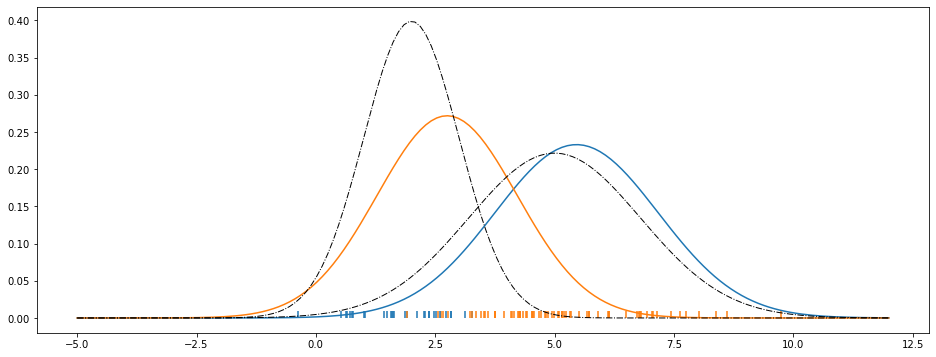

In [27]:
fitted_m = [stats.norm(mu, std) for mu, std in zip(mu.data, std.data)]

plt.figure(figsize=(16, 6))
plt.vlines(x_i, 0, 0.01, color=np.array(['C0', 'C1'])[z])
plt.plot(x, fitted_m[0].pdf(x))
plt.plot(x, fitted_m[1].pdf(x))
plt.plot(x, generative_m[0].pdf(x), color='black', lw=1, ls='-.')
plt.plot(x, generative_m[1].pdf(x), color='black', lw=1, ls='-.')


## GMM

### Expectation step
$$\begin{eqnarray}
w_{ij} := p(z_i = j|x_i; \theta) \\
\mu_j := \frac{\sum_{i=1}^nw_{ij} x_i} {\sum_{i=1}^nw_{ij}}
\end{eqnarray}$$


### Maximization step
$$\begin{eqnarray}
\mu_j := \frac{\sum_{i=1}^nw_{ij} x_i} {\sum_{i=1}^nw_{ij}} \\
\sigma_j :=  \sqrt{\frac{\sum_{i=1}^nw_{ij}(x_i - \mu_j)^2} {\sum_{i=1}^nw_{ij}}}
\end{eqnarray}$$

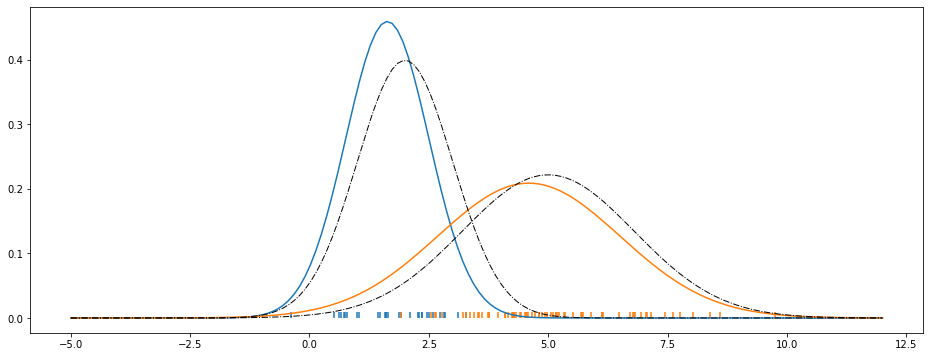

In [39]:
class EM:
    def __init__(self, k):
        self.k = k
        self.mu = None
        self.std = np.ones(k)
        self.w_ij = None
        self.phi = np.ones(k) / k

    def expectation_step(self, x):
        for z_i in range(self.k):
            self.w_ij[z_i] = stats.norm(self.mu[z_i], self.std[z_i]).pdf(x) * self.phi[z_i]
        
        # normalize zo that marginalizing z would lead to p = 1
        self.w_ij /= self.w_ij.sum(0)

    def maximization_step(self, x):
        self.phi = self.w_ij.mean(1)
        self.std = ((self.w_ij * (x - self.mu[:, None])**2).sum(1) / self.w_ij.sum(1))**0.5
        self.mu = (self.w_ij * x).sum(1) / self.w_ij.sum(1)

    def fit(self, x):
        self.mu = np.random.uniform(x.min(), x.max(), size=self.k)
        self.w_ij = np.zeros((self.k, x.shape[0]))

        last_mu = np.ones(self.k) * np.inf
        while ~np.all(np.isclose(self.mu, last_mu)):
            last_mu = self.mu
            self.expectation_step(x)
            self.maximization_step(x)

m = EM(2)
m.fit(np.array(x_i))

fitted_m = [stats.norm(mu, std) for mu, std in zip(m.mu, m.std)]

plt.figure(figsize=(16, 6))
plt.vlines(x_i, 0, 0.01, color=np.array(['C0', 'C1'])[z])
plt.plot(x, fitted_m[0].pdf(x))
plt.plot(x, fitted_m[1].pdf(x))
plt.plot(x, generative_m[0].pdf(x), color='black', lw=1, ls='-.')
plt.plot(x, generative_m[1].pdf(x), color='black', lw=1, ls='-.')